In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

cmap = plt.get_cmap("Set1")
colors = cmap.colors

In [28]:
run_id, run_path = get_latest_results_directory("../../results/bb-ntrees/")
# run_id = 10
# run_path = "C:/Users/Peter/Documents/Peter/9-Graduate-School/2-dsrg/explainable-ad/code/HEEAD/results/bb-ntrees/run-{:003d}".format(run_id)
fig_output_path = make_fig_directory(run_id)
found_ds, results = load_results(run_path, group_fields=["explainer", "n_trees"])

all_results = pd.DataFrame(columns=[
                "explainer",
                "n_trees",
                "max_depth",
                "n_samples",
                "n_samples_explained",
                "n_features",
                "accuracy",
                "precision",
                "recall",
                "f1",
                "q",
                "jaccard",
                "coverage_ratio",
                "mean_distance",
                "mean_length",
                "init_time",
                "runtime",
                "ext_min",
                "ext_avg",
                "ext_max",
                "avg_nnodes",
                "avg_nleaves",
                "avg_depth"
            ])

for ds in found_ds:
    results[ds]["sample_runtime"] = results[ds].runtime / results[ds].n_samples_explained # * 1000
    results[ds]["init_time"] = results[ds]["init_time"] * 1000
    results[ds]["mdr"] = results[ds].mean_distance / np.sqrt(results[ds].n_features) * 100

for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)
# idx_neg = all_results["clique_size"] < 0
# all_results.loc[idx_neg, "clique_size"] = 0

found_explainers = all_results["explainer"].unique()
explainer_dict = {
    "AFT" : "AFT",
    "FACET" : "FACET",
    "FACETPaths" : "FACETPaths",
    "FACETTrees" : "FACETTrees",
    "FACETGrow" : "FACETGrow",
    "FACETBranchBound" : "FACETBranchBound",
    "OCEAN" : "OCEAN",
    "MACE": "MACE"
}
explainer_colors = {
    "AFT" : colors[3] , # purple
    "FACET" : colors[0], # red
    "FACETPaths" : colors[0], # red
    "FACETTrees" : colors[0], # red
    "FACETGrow" : colors[0], # red
    "FACETBranchBound" : colors[0], # red
    "OCEAN" : colors[4], # orange
    "MACE": colors[1] # blue
}
explainer_names = []
for e in found_explainers:
    explainer_names.append(explainer_dict[e])

print("Generating figures for run-{:03d}".format(run_id))
print("Datasets included:")
for ds in found_ds:
    print("\t", ds)
print("Explainers included:")
for expl in found_explainers:
    print("\t", expl)

Generating figures for run-013
Datasets included:
	 vertebral
Explainers included:
	 FACETBranchBound


In [29]:
all_results.head()

,explainer,n_trees,max_depth,n_samples,n_samples_explained,n_features,accuracy,precision,recall,f1,...,runtime,ext_min,ext_avg,ext_max,avg_nnodes,avg_nleaves,avg_depth,dataset,mdr,sample_runtime
0,FACETBranchBound,5,3,3,3,6,1.0,1.0,1.0,1.0,...,0.112001,17,23.000000,32,13.000000,7.000000,3.0,vertebral,1.485949,0.037334
1,FACETBranchBound,10,3,3,3,6,1.0,1.0,1.0,1.0,...,4.531000,43,297.333333,541,12.800000,6.900000,3.0,vertebral,1.551628,1.510333
2,FACETBranchBound,15,3,3,3,6,1.0,1.0,1.0,1.0,...,73.368404,862,2887.000000,6423,13.266667,7.133333,3.0,vertebral,1.624743,24.456135
3,FACETBranchBound,20,3,3,3,6,1.0,1.0,1.0,1.0,...,1426.560652,4068,30283.666667,58895,13.100000,7.050000,3.0,vertebral,2.700270,475.520217


In [30]:
def render_bar_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):
    fig, ax = plt.subplots()
    pos = np.arange(len(found_ds))
    bar_width = 0.15

    yvalues = all_results[yfeature].unique()

    for i in range(len(yvalues)):
        isExpl = all_results[yfeature] == yvalues[i]
        hbars = ax.barh(y=(pos + bar_width*i), width=all_results[isExpl][xfeature], height=bar_width, log=xlog, color=explainer_colors[yvalues[i]])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if not lloc:
        lloc = "best"
    plt.legend(explainer_names, loc=lloc)
    plt.yticks(pos, found_ds)

    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name, bbox_inches="tight")

In [31]:
def render_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):
    plt.figure()

    for i in range(len(found_ds)):
        ds = found_ds[i]
        plt.plot(results[ds][xfeature], results[ds][yfeature], label=ds, lw=2.0)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.xlim(xrange)
    # plt.ylim(yrange)
    plt.legend(loc=lloc)
    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name, bbox_inches="tight")

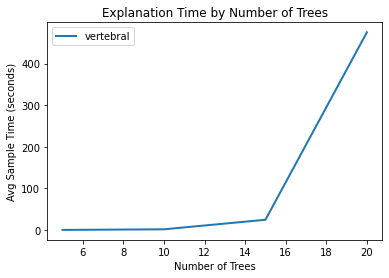

In [32]:
render_plot("n_trees", "sample_runtime", "Number of Trees", "Avg Sample Time (seconds)", "Explanation Time by Number of Trees", "sampletime_trees.png")

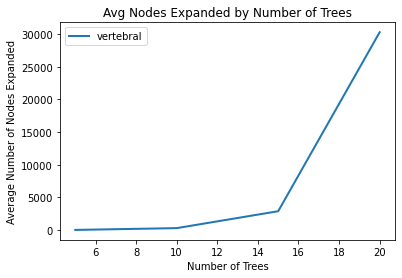

In [33]:
render_plot("n_trees", "ext_avg", "Number of Trees", "Average Number of Nodes Expanded", "Avg Nodes Expanded by Number of Trees", "avgnodes_trees.png")

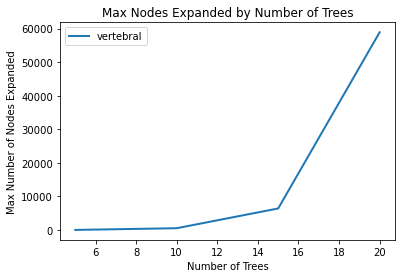

In [34]:
render_plot("n_trees", "ext_max", "Number of Trees", "Max Number of Nodes Expanded", "Max Nodes Expanded by Number of Trees", "maxnodes_trees.png")

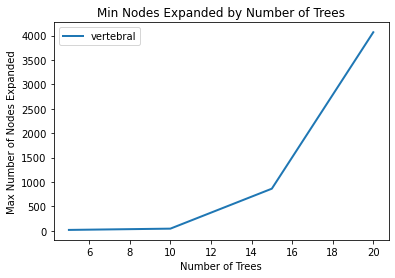

In [35]:
render_plot("n_trees", "ext_min", "Number of Trees", "Max Number of Nodes Expanded", "Min Nodes Expanded by Number of Trees", "minnodes_trees.png")

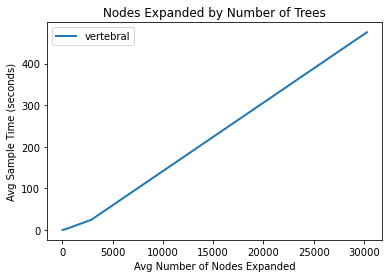

In [36]:
render_plot("ext_avg", "sample_runtime", "Avg Number of Nodes Expanded", "Avg Sample Time (seconds)", "Nodes Expanded by Number of Trees", "sampletime_avgnodes.png")

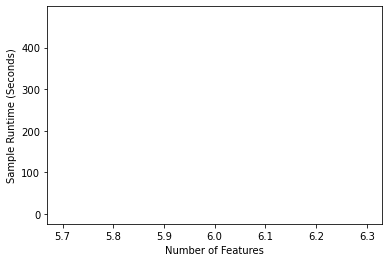

In [37]:
feature_data = all_results[["dataset", "n_features", "n_trees", "sample_runtime"]].sort_values(["n_features"])
feature_data.head()

plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Sample Runtime (Seconds)")

tree_options = feature_data["n_trees"].unique()
for ntrees in tree_options:
    match_rows = feature_data["n_trees"] == ntrees
    plt.plot(feature_data[match_rows]["n_features"], feature_data[match_rows]["sample_runtime"], label=ds, lw=2.0)

In [38]:
found_ds, results = load_results(run_path, group_fields=["explainer", "max_depth"])

all_results = pd.DataFrame(columns=[
                "explainer",
                "n_trees",
                "max_depth",
                "n_samples",
                "n_samples_explained",
                "n_features",
                "accuracy",
                "precision",
                "recall",
                "f1",
                "q",
                "jaccard",
                "coverage_ratio",
                "mean_distance",
                "mean_length",
                "init_time",
                "runtime",
                "ext_min",
                "ext_avg",
                "ext_max",
                "avg_nnodes",
                "avg_nleaves",
                "avg_depth"
            ])

for ds in found_ds:
    results[ds]["sample_runtime"] = results[ds].runtime / results[ds].n_samples_explained # * 1000
    results[ds]["init_time"] = results[ds]["init_time"] * 1000
    results[ds]["mdr"] = results[ds].mean_distance / np.sqrt(results[ds].n_features) * 100

for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)

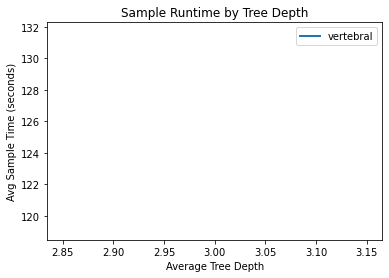

In [39]:
render_plot("avg_depth", "sample_runtime", "Average Tree Depth", "Avg Sample Time (seconds)", "Sample Runtime by Tree Depth", "sampletime_avgdepth.png")